# GCN Feature Matrix Creation for London LSOA Analysis

This notebook creates an optimal feature matrix for Graph Convolutional Networks (GCN) using London Lower Layer Super Output Area (LSOA) data. The pipeline combines multiple data sources and applies spatial correlation-based imputation for missing values.

## Workflow Overview:
1. **Data Loading & Cleaning** - Load and preprocess tabular and spatial datasets
2. **Spatial Feature Engineering** - Calculate spatial features from geographic layers
3. **Feature Selection** - Select optimal features for GCN analysis
4. **Spatial Imputation** - Handle missing values using spatial correlation
5. **Standardization** - Apply feature scaling for optimal model performance
6. **Export Results** - Save cleaned datasets and documentation

## 1. Import Libraries and Setup

In [1]:
# Core libraries
import os
import zipfile
import requests
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Spatial analysis
import geopandas as gpd
import fiona
from shapely.ops import nearest_points
from scipy.spatial import cKDTree

# Machine learning
from sklearn.preprocessing import StandardScaler

print("All libraries imported successfully")

All libraries imported successfully


## 2. Data Loading Functions

In [2]:
def download_and_extract_shapefiles():
    """Download and extract spatial data layers."""
    zip_paths = {
        'lsoa': 'https://github.com/IflyNY2PR/CASA0004/raw/071702afad8b880e82c9ed33500e52ba2508e055/data-preparation/shapefiles/lsoa.zip',
        'street': 'https://github.com/IflyNY2PR/CASA0004/raw/071702afad8b880e82c9ed33500e52ba2508e055/data-preparation/shapefiles/streetnetwork.zip',
        'station': 'https://github.com/IflyNY2PR/CASA0004/raw/071702afad8b880e82c9ed33500e52ba2508e055/data-preparation/shapefiles/station.zip',
        'landuse': 'https://github.com/IflyNY2PR/CASA0004/raw/071702afad8b880e82c9ed33500e52ba2508e055/data-preparation/shapefiles/landuse.zip',
        'rail': 'https://github.com/IflyNY2PR/CASA0004/raw/071702afad8b880e82c9ed33500e52ba2508e055/data-preparation/shapefiles/railnetwork.zip'
    }
    
    for name, zip_url in zip_paths.items():
        outdir = f'./{name}'
        zip_path = f'./{name}.zip'
        
        if not os.path.isdir(outdir):
            os.makedirs(outdir, exist_ok=True)
            print(f"Downloading {name}...")
            response = requests.get(zip_url)
            response.raise_for_status()
            
            with open(zip_path, 'wb') as f:
                f.write(response.content)
            
            print(f"Extracting {name}...")
            with zipfile.ZipFile(zip_path, 'r') as z:
                z.extractall(outdir)
            
            os.remove(zip_path)

def find_shp(dirpath):
    """Find .shp file in directory."""
    for root, _, files in os.walk(dirpath):
        for f in files:
            if f.lower().endswith('.shp') and not f.startswith('._'):
                return os.path.join(root, f)
    raise FileNotFoundError(f"No .shp in {dirpath}")

def load_gdf(shp_path):
    """Load shapefile as GeoDataFrame."""
    with fiona.open(shp_path) as src:
        feats = list(src)
        return gpd.GeoDataFrame.from_features(feats, crs=src.crs)

print("Helper functions defined")

Helper functions defined


## 3. Load and Clean Tabular Data

In [3]:
def load_tabular_data():
    """Load and clean all tabular datasets."""
    
    # Data source URLs
    data_urls = {
        'ptal': 'https://raw.githubusercontent.com/IflyNY2PR/CASA0004/071702afad8b880e82c9ed33500e52ba2508e055/data-preparation/Infrastructure/LSOA_aggregated_PTAL_stats_2023.csv',
        'demographics': 'https://raw.githubusercontent.com/IflyNY2PR/CASA0004/071702afad8b880e82c9ed33500e52ba2508e055/data-preparation/social/demographic/lsoa-data.csv',
        'sentiment': 'https://raw.githubusercontent.com/IflyNY2PR/CASA0004/071702afad8b880e82c9ed33500e52ba2508e055/data-preparation/social/lsoa_sentiment_stats.csv'
    }
    
    # Load datasets
    print("Loading tabular datasets...")
    raw_data = {}
    for name, url in data_urls.items():
        print(f"  - Loading {name}...")
        raw_data[name] = pd.read_csv(url, encoding='latin-1', low_memory=False)
    
    # Clean PTAL data
    ptal = raw_data['ptal']
    ptal_code_col = ptal.columns[0]  # Handle BOM character
    ptal_clean = ptal[[ptal_code_col, 'mean_AI', 'Shape_Area']].rename(
        columns={
            ptal_code_col: 'LSOA_CODE', 
            'mean_AI': 'MeanPTAL', 
            'Shape_Area': 'Area_m2'
        }
    )
    # Convert area from square meters to square kilometers
    ptal_clean['Area_km2'] = ptal_clean['Area_m2'] / 1000000
    # Drop the intermediate area column to keep things clean
    ptal_clean = ptal_clean.drop('Area_m2', axis=1)
    
    # Clean demographics data (including education and population)
    demo = raw_data['demographics']
    demo_code_col = demo.columns[0]
    
    # Find population columns
    pop_cols = [c for c in demo.columns if 'Population' in c and '2023' in c]
    if not pop_cols:
        pop_cols = [c for c in demo.columns if 'Population' in c]
    
    # Find education columns (Level 4 qualifications and above)
    # Look specifically for the percentage column first
    edu_pct_cols = [c for c in demo.columns if 'Level 4' in c and '%' in c and ('qualifications' in c.lower() and 'above' in c.lower())]
    edu_count_cols = [c for c in demo.columns if 'Level 4' in c and '%' not in c and ('qualifications' in c.lower() and 'above' in c.lower())]
    
    # Prefer percentage columns over count columns
    if edu_pct_cols:
        edu_cols = edu_pct_cols
        print(f"Using percentage column for education: {edu_pct_cols[0]}")
    elif edu_count_cols:
        edu_cols = edu_count_cols
        print(f"Using count column for education: {edu_count_cols[0]}")
    else:
        edu_cols = []
        print(f"No education columns found")
    
    demo_cols = [demo_code_col]
    demo_names = ['LSOA_CODE']
    
    if pop_cols:
        demo_cols.append(pop_cols[0])
        demo_names.append('Population')
    
    if edu_cols:
        demo_cols.append(edu_cols[0])
        demo_names.append('Education_HighLevel_pct')
    
    demo_clean = demo[demo_cols].copy()
    demo_clean.columns = demo_names
    
    # Convert education data to numeric
    if 'Education_HighLevel_pct' in demo_clean.columns:
        demo_clean['Education_HighLevel_pct'] = pd.to_numeric(
            demo_clean['Education_HighLevel_pct'], errors='coerce'
        )
        
        # Show final education data summary
        edu_final = demo_clean['Education_HighLevel_pct'].dropna()
        print(f"  Education data summary:")
        print(f"  Range: {edu_final.min():.1f}% to {edu_final.max():.1f}%")
        print(f"  Mean: {edu_final.mean():.1f}%")
    
    # Clean sentiment data
    sent = raw_data['sentiment']
    sent_clean = sent[['LSOA', 'Avg_Sentiment_Score', 'Sentiment_Std', 'Total_Reviews']].rename(
        columns={
            'LSOA': 'LSOA_CODE',
            'Avg_Sentiment_Score': 'MeanSentiment',
            'Sentiment_Std': 'SentimentSD',
            'Total_Reviews': 'ReviewCount'
        }
    )
    
    # Merge all datasets
    print("Merging datasets...")
    df_merged = (
        demo_clean
        .merge(ptal_clean, on='LSOA_CODE', how='outer')
        .merge(sent_clean, on='LSOA_CODE', how='outer')
    )
    
    print(f"Tabular data loaded and merged: {df_merged.shape}")
    
    # Verify PTAL features are correctly loaded
    ptal_features = ['MeanPTAL', 'Area_km2']
    ptal_status = {}
    for feature in ptal_features:
        if feature in df_merged.columns:
            non_null = df_merged[feature].notna().sum()
            ptal_status[feature] = f"{non_null:,} values"
        else:
            ptal_status[feature] = "MISSING"
    
    print(f"PTAL Features Status:")
    for feature, status in ptal_status.items():
        print(f"  {feature}: {status}")
    
    return df_merged

# Load tabular data
df_tabular = load_tabular_data()

Loading tabular datasets...
  - Loading ptal...
  - Loading demographics...
  - Loading sentiment...
Using percentage column for education: Qualifications;% Highest level of qualification: Level 4 qualifications and above;2011
  Education data summary:
  Range: 8.3% to 83.8%
  Mean: 37.3%
Merging datasets...
Tabular data loaded and merged: (5172, 8)
PTAL Features Status:
  MeanPTAL: 4,994 values
  Area_km2: 4,994 values


## 4. Load Spatial Data

In [4]:
# Download and extract spatial data
download_and_extract_shapefiles()

# Load spatial layers
print("Loading spatial datasets...")
lsoa_gdf = load_gdf(find_shp('./lsoa')).to_crs('EPSG:27700')
street_gdf = load_gdf(find_shp('./street')).to_crs('EPSG:27700')
station_gdf = load_gdf(find_shp('./station')).to_crs('EPSG:27700')
landuse_gdf = load_gdf(find_shp('./landuse')).to_crs('EPSG:27700')
rail_gdf = load_gdf(find_shp('./rail')).to_crs('EPSG:27700')

# Identify LSOA code column
possible_code_cols = [c for c in lsoa_gdf.columns if 'LSOA' in c.upper() and lsoa_gdf[c].dtype == object]
lsoa_code_col = possible_code_cols[0] if possible_code_cols else 'code'

print(f"Spatial data loaded:")
print(f"  - LSOA polygons: {lsoa_gdf.shape}")
print(f"  - Street network: {street_gdf.shape}")
print(f"  - Stations: {station_gdf.shape}")
print(f"  - Land use: {landuse_gdf.shape}")
print(f"  - Rail network: {rail_gdf.shape}")
print(f"  - LSOA code column: '{lsoa_code_col}'")

Loading spatial datasets...
Spatial data loaded:
  - LSOA polygons: (4719, 7)
  - Street network: (115305, 2)
  - Stations: (21002, 5)
  - Land use: (30775, 5)
  - Rail network: (11777, 5)
  - LSOA code column: 'code'


## 5. Filter to London LSOAs Only

In [5]:
# Get London LSOA codes from spatial data
london_lsoa_codes = set(lsoa_gdf[lsoa_code_col].unique())
print(f"London LSOAs in spatial data: {len(london_lsoa_codes)}")

# Filter tabular data to London only
df_london = df_tabular[df_tabular['LSOA_CODE'].isin(london_lsoa_codes)].copy()
print(f"London LSOAs in tabular data: {len(df_london)}")

# Data coverage summary
print(f"\n Data Coverage Summary:")
for col in df_london.columns:
    if col != 'LSOA_CODE':
        non_null = df_london[col].notna().sum()
        pct = (non_null / len(df_london)) * 100
        print(f"  {col}: {non_null:,}/{len(df_london):,} ({pct:.1f}%)")

print(f"\n Data filtered to London LSOAs: {df_london.shape}")

London LSOAs in spatial data: 4719
London LSOAs in tabular data: 4719

 Data Coverage Summary:
  Population: 4,719/4,719 (100.0%)
  Education_HighLevel_pct: 4,719/4,719 (100.0%)
  MeanPTAL: 4,547/4,719 (96.4%)
  Area_km2: 4,547/4,719 (96.4%)
  MeanSentiment: 2,678/4,719 (56.7%)
  SentimentSD: 1,572/4,719 (33.3%)
  ReviewCount: 2,678/4,719 (56.7%)

 Data filtered to London LSOAs: (4719, 8)


## 6. Spatial Feature Engineering

In [6]:
def calculate_spatial_features(lsoa_gdf, df_london, station_gdf, rail_gdf, street_gdf, landuse_gdf):
    """Calculate spatial features for each LSOA."""
    
    print("🔧 Calculating spatial features...")
    
    # Merge LSOA spatial data with tabular data
    df_spatial = lsoa_gdf.merge(df_london, left_on=lsoa_code_col, right_on='LSOA_CODE', how='left')
    centroids = df_spatial.geometry.centroid
    
    # 1. Transport accessibility features
    print("  - Transport accessibility features...")
    station_coords = np.array([[pt.x, pt.y] for pt in station_gdf.geometry])
    station_tree = cKDTree(station_coords)
    centroid_coords = np.array([[pt.x, pt.y] for pt in centroids])
    
    # Nearest station distances
    nearest_station_dist, _ = station_tree.query(centroid_coords)
    
    # Stations within 500m
    stations_within_500m = []
    for centroid in centroids:
        buffer = centroid.buffer(500)
        stations_in = station_gdf[station_gdf.geometry.within(buffer)]
        stations_within_500m.append(len(stations_in))
    
    # Rail network distances
    rail_coords = np.array([[geom.coords[0][0], geom.coords[0][1]] for geom in rail_gdf.geometry])
    rail_tree = cKDTree(rail_coords)
    nearest_rail_dist, _ = rail_tree.query(centroid_coords)
    
    # 2. Street network features
    print("  - Street network features...")
    street_stats = []
    for idx, lsoa in df_spatial.iterrows():
        streets_clipped = street_gdf.clip(lsoa.geometry)
        
        if len(streets_clipped) > 0:
            total_length = streets_clipped.geometry.length.sum()
            area = lsoa.geometry.area
            street_density = total_length / area if area > 0 else 0
            num_segments = len(streets_clipped)
        else:
            total_length = 0
            street_density = 0
            num_segments = 0
        
        street_stats.append({
            'StreetLength_m': total_length,
            'StreetDensity_m_per_m2': street_density,
            'StreetSegments': num_segments
        })
    
    # 3. Land use features
    print("  - Land use features...")
    landuse_cols = [c for c in landuse_gdf.columns 
                   if landuse_gdf[c].dtype == 'object' and len(landuse_gdf[c].unique()) < 50]
    
    if landuse_cols:
        landuse_col = landuse_cols[0]
        landuse_stats = []
        
        for idx, lsoa in df_spatial.iterrows():
            land_int = landuse_gdf[landuse_gdf.geometry.intersects(lsoa.geometry)]
            
            if len(land_int) > 0:
                diversity = land_int[landuse_col].nunique()
                areas = []
                for _, lu in land_int.iterrows():
                    intersection = lu.geometry.intersection(lsoa.geometry)
                    areas.append(intersection.area)
                total_area = sum(areas)
            else:
                diversity = 0
                total_area = 0
            
            landuse_stats.append({
                'LandUse_Diversity': diversity,
                'LandUse_Area': total_area
            })
    else:
        landuse_stats = [{'LandUse_Diversity': 0, 'LandUse_Area': 0} for _ in range(len(df_spatial))]
    
    # Combine all spatial features
    spatial_features = pd.DataFrame({
        'LSOA_CODE': df_spatial['LSOA_CODE'],
        'NearestStation_m': nearest_station_dist,
        'StationsWithin500m': stations_within_500m,
        'NearestRail_m': nearest_rail_dist,
    })
    
    # Add street and landuse features
    street_df = pd.DataFrame(street_stats)
    landuse_df = pd.DataFrame(landuse_stats)
    
    spatial_features = pd.concat([spatial_features, street_df, landuse_df], axis=1)
    
    print(f" Spatial features calculated: {spatial_features.shape}")
    return spatial_features

# Calculate spatial features
spatial_features = calculate_spatial_features(
    lsoa_gdf, df_london, station_gdf, rail_gdf, street_gdf, landuse_gdf
)

🔧 Calculating spatial features...
  - Transport accessibility features...
  - Street network features...
  - Land use features...
 Spatial features calculated: (4719, 9)


## 7. Create Combined Feature Matrix

In [7]:
# Combine tabular and spatial features
df_combined = df_london.merge(spatial_features, on='LSOA_CODE', how='left')

# Area_km2 should already be available from PTAL data, but fix if needed using spatial data
if 'Area_km2' in df_combined.columns and df_combined['Area_km2'].isnull().any():
    print("Fixing missing Area_km2 values using spatial geometry...")
    # For any missing area values, calculate from spatial geometry
    missing_area_mask = df_combined['Area_km2'].isnull()
    if missing_area_mask.any():
        area_mapping = lsoa_gdf.set_index(lsoa_code_col).geometry.area / 1000000  # Convert m² to km²
        df_combined.loc[missing_area_mask, 'Area_km2'] = df_combined.loc[missing_area_mask, 'LSOA_CODE'].map(area_mapping)

# Convert all features to numeric
numeric_columns = [col for col in df_combined.columns if col != 'LSOA_CODE']
for col in numeric_columns:
    if df_combined[col].dtype == 'object':
        df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

print(f" Combined feature matrix created: {df_combined.shape}")
print(f"Features: {list(df_combined.columns)}")

Fixing missing Area_km2 values using spatial geometry...
 Combined feature matrix created: (4719, 16)
Features: ['LSOA_CODE', 'Population', 'Education_HighLevel_pct', 'MeanPTAL', 'Area_km2', 'MeanSentiment', 'SentimentSD', 'ReviewCount', 'NearestStation_m', 'StationsWithin500m', 'NearestRail_m', 'StreetLength_m', 'StreetDensity_m_per_m2', 'StreetSegments', 'LandUse_Diversity', 'LandUse_Area']


## 8. Feature Selection for GCN

In [8]:
# Define optimal feature set for GCN
selected_features = [
    'Education_HighLevel_pct', 'MeanPTAL', 'Population', 'Area_km2',
    'MeanSentiment', 'SentimentSD', 'ReviewCount', 'NearestStation_m',
    'StationsWithin500m', 'NearestRail_m', 'StreetLength_m',
    'StreetDensity_m_per_m2', 'StreetSegments', 'LandUse_Diversity', 'LandUse_Area'
]

# Check feature availability
available_features = [f for f in selected_features if f in df_combined.columns]
missing_features = [f for f in selected_features if f not in df_combined.columns]

print(f"Selected features available: {len(available_features)}/{len(selected_features)}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Create custom GCN feature matrix
gcn_features = ['LSOA_CODE'] + available_features
df_gcn = df_combined[gcn_features].copy()

print(f"\n GCN feature matrix: {df_gcn.shape}")
print(f"Features: {available_features}")

# Check missing values
missing_summary = df_gcn.isnull().sum()
features_with_missing = missing_summary[missing_summary > 0]

if len(features_with_missing) > 0:
    print(f"\n Features with missing values:")
    for feature, count in features_with_missing.items():
        pct = (count / len(df_gcn)) * 100
        print(f"  {feature}: {count} ({pct:.1f}%)")
else:
    print(f"\n No missing values in feature matrix")

Selected features available: 15/15

 GCN feature matrix: (4719, 16)
Features: ['Education_HighLevel_pct', 'MeanPTAL', 'Population', 'Area_km2', 'MeanSentiment', 'SentimentSD', 'ReviewCount', 'NearestStation_m', 'StationsWithin500m', 'NearestRail_m', 'StreetLength_m', 'StreetDensity_m_per_m2', 'StreetSegments', 'LandUse_Diversity', 'LandUse_Area']

 Features with missing values:
  MeanPTAL: 172 (3.6%)
  MeanSentiment: 2041 (43.3%)
  SentimentSD: 3147 (66.7%)
  ReviewCount: 2041 (43.3%)


## 9. Spatial Correlation-Based Imputation

In [9]:
def spatial_imputation(df_gcn, lsoa_gdf, lsoa_code_col):
    """Apply spatial correlation-based imputation for missing values."""
    
    missing_summary = df_gcn.isnull().sum()
    features_with_missing = missing_summary[missing_summary > 0]
    
    if len(features_with_missing) == 0:
        print(" No missing values found - no imputation needed")
        return df_gcn.copy()
    
    print(f"🔧 Applying spatial imputation to {len(features_with_missing)} features...")
    
    df_imputed = df_gcn.copy()
    
    # Merge with spatial data for spatial operations
    spatial_data = lsoa_gdf[[lsoa_code_col, 'geometry']].copy()
    df_with_geometry = pd.merge(
        df_imputed, spatial_data,
        left_on='LSOA_CODE', right_on=lsoa_code_col, how='left'
    )
    df_with_geometry = gpd.GeoDataFrame(df_with_geometry, geometry='geometry')
    
    # Apply spatial imputation for each feature with missing values
    for feature in features_with_missing.index:
        if feature == 'LSOA_CODE':
            continue
            
        print(f"  Processing {feature}...")
        missing_mask = df_with_geometry[feature].isnull()
        missing_indices = df_with_geometry[missing_mask].index
        
        imputed_values = []
        
        for idx in missing_indices:
            missing_geometry = df_with_geometry.loc[idx, 'geometry']
            
            if missing_geometry is None or pd.isna(missing_geometry):
                # Use median if no geometry
                fill_value = df_with_geometry[feature].median()
            else:
                # Try different distance thresholds
                fill_value = None
                for distance in [500, 1000, 2000, 5000, 10000]:
                    buffer = missing_geometry.buffer(distance)
                    intersecting = df_with_geometry[df_with_geometry.geometry.intersects(buffer)]
                    neighbor_values = intersecting[feature].dropna()
                    neighbor_values = neighbor_values[neighbor_values.index != idx]
                    
                    if len(neighbor_values) >= 3:
                        # Distance-weighted average
                        weights = []
                        values = []
                        
                        for neighbor_idx in neighbor_values.index:
                            neighbor_geom = df_with_geometry.loc[neighbor_idx, 'geometry']
                            if neighbor_geom is not None:
                                dist = missing_geometry.distance(neighbor_geom)
                                if dist > 0:
                                    weight = 1 / (dist + 100)
                                    weights.append(weight)
                                    values.append(neighbor_values.loc[neighbor_idx])
                        
                        if len(values) > 0:
                            weights = np.array(weights)
                            values = np.array(values)
                            fill_value = np.average(values, weights=weights)
                            break
                    elif len(neighbor_values) >= 1:
                        fill_value = neighbor_values.mean()
                        break
                
                # Fallback to median if no spatial neighbors found
                if fill_value is None or np.isnan(fill_value):
                    fill_value = df_with_geometry[feature].median()
            
            imputed_values.append(fill_value)
        
        # Apply imputed values
        df_imputed.loc[df_imputed[feature].isnull(), feature] = imputed_values
        print(f"    Imputed {len(imputed_values)} values")
    
    # Verify no missing values remain
    remaining_missing = df_imputed.isnull().sum().sum()
    print(f" Spatial imputation completed. Remaining missing values: {remaining_missing}")
    
    return df_imputed

# Apply spatial imputation
df_gcn_imputed = spatial_imputation(df_gcn, lsoa_gdf, lsoa_code_col)

🔧 Applying spatial imputation to 4 features...
  Processing MeanPTAL...
    Imputed 172 values
  Processing MeanSentiment...
    Imputed 2041 values
  Processing SentimentSD...
    Imputed 3147 values
  Processing ReviewCount...
    Imputed 2041 values
 Spatial imputation completed. Remaining missing values: 0


## 10. Feature Standardization

In [10]:
# Standardize features (mean=0, std=1)
feature_cols = [col for col in df_gcn_imputed.columns if col != 'LSOA_CODE']
scaler = StandardScaler()

# Apply standardization
features_scaled = scaler.fit_transform(df_gcn_imputed[feature_cols])

# Create standardized dataframe
df_gcn_scaled = pd.DataFrame(
    features_scaled, 
    columns=feature_cols,
    index=df_gcn_imputed.index
)
df_gcn_scaled['LSOA_CODE'] = df_gcn_imputed['LSOA_CODE'].values

# Reorder columns
df_gcn_scaled = df_gcn_scaled[['LSOA_CODE'] + feature_cols]

print(f" Features standardized: {df_gcn_scaled.shape}")
print(f"Feature means (should be ~0): {df_gcn_scaled[feature_cols].mean().abs().max():.6f}")
print(f"Feature stds (should be ~1): {df_gcn_scaled[feature_cols].std().min():.3f} to {df_gcn_scaled[feature_cols].std().max():.3f}")

# Display sample
print(f"\n Sample of standardized GCN feature matrix:")
print(df_gcn_scaled.head())

 Features standardized: (4719, 16)
Feature means (should be ~0): 0.000000
Feature stds (should be ~1): 1.000 to 1.000

 Sample of standardized GCN feature matrix:
   LSOA_CODE  Education_HighLevel_pct  MeanPTAL  Population  Area_km2  \
0  E01000001                 2.752961  5.498077    0.435383 -0.407064   
1  E01000002                 2.862763  6.435168   -0.090485 -0.153782   
2  E01000003                 1.325529  3.588845    0.254346 -0.589046   
3  E01000005                -0.204843  6.176879   -1.827576 -0.253605   
4  E01000006                -0.314645  0.979416    0.422452 -0.364218   

   MeanSentiment  SentimentSD  ReviewCount  NearestStation_m  \
0      -1.238606     1.682900    -0.005206         -1.240113   
1      -0.479543     0.370189     0.422149          0.217765   
2      -2.099400     0.226084    -0.153997         -0.467001   
3       0.702093    -0.561413    -0.048595         -1.107029   
4      -0.400212    -0.189228    -0.024191          1.988550   

   StationsWi

## 11. Export Results

In [11]:
# Define output files
output_files = {
    'imputed': 'gcn_feature_matrix_spatial_imputed.csv',
    'scaled': 'gcn_feature_matrix_spatial_imputed_scaled.csv',
    'with_geometry': 'gcn_feature_matrix_with_geometry.csv',
    'documentation': 'gcn_feature_matrix_documentation.csv',
    'summary_stats': 'gcn_feature_matrix_summary_stats.csv'
}

print("Saving GCN feature matrices...")

# 1. Save imputed (unscaled) matrix
df_gcn_imputed.to_csv(output_files['imputed'], index=False)
print(f"Saved imputed matrix: {output_files['imputed']}")

# 2. Save scaled matrix (RECOMMENDED)
df_gcn_scaled.to_csv(output_files['scaled'], index=False)
print(f"Saved scaled matrix: {output_files['scaled']} (RECOMMENDED)")

# 3. Save matrix with geometry
df_with_geometry = pd.merge(
    df_gcn_scaled, lsoa_gdf[[lsoa_code_col, 'geometry']],
    left_on='LSOA_CODE', right_on=lsoa_code_col, how='left'
).drop(lsoa_code_col, axis=1)

df_with_geometry['geometry_wkt'] = df_with_geometry['geometry'].apply(
    lambda x: x.wkt if x is not None else None
)
df_geometry_export = df_with_geometry.drop('geometry', axis=1)
df_geometry_export.to_csv(output_files['with_geometry'], index=False)
print(f"Saved matrix with geometry: {output_files['with_geometry']}")

# 4. Create and save documentation
feature_docs = []
feature_descriptions = {
    'Education_HighLevel_pct': 'Percentage of population with Level 4 qualifications and above',
    'MeanPTAL': 'Mean Public Transport Accessibility Index',
    'Population': 'Population count in LSOA',
    'Area_km2': 'LSOA area (square kilometers, from PTAL dataset)',
    'MeanSentiment': 'Average sentiment score (-1 to 1)',
    'SentimentSD': 'Standard deviation of sentiment scores',
    'ReviewCount': 'Number of reviews/posts analyzed',
    'NearestStation_m': 'Distance to nearest station (meters)',
    'StationsWithin500m': 'Number of stations within 500m',
    'NearestRail_m': 'Distance to nearest rail line (meters)',
    'StreetLength_m': 'Total street length (meters)',
    'StreetDensity_m_per_m2': 'Street density (m/m²)',
    'StreetSegments': 'Number of street segments',
    'LandUse_Diversity': 'Number of land use types',
    'LandUse_Area': 'Total land use area (m²)'
}

for feature in feature_cols:
    feature_docs.append({
        'Feature': feature,
        'Description': feature_descriptions.get(feature, 'No description'),
        'Data_Type': 'float64 (standardized)',
        'Missing_Values': 'Spatially imputed',
        'Standardized': 'Yes (mean≈0, std≈1)'
    })

pd.DataFrame(feature_docs).to_csv(output_files['documentation'], index=False)
print(f"Saved documentation: {output_files['documentation']}")

# 5. Save summary statistics
df_gcn_scaled[feature_cols].describe().to_csv(output_files['summary_stats'])
print(f"Saved summary statistics: {output_files['summary_stats']}")

print(f"\nGCN FEATURE MATRIX PIPELINE COMPLETED!")
print(f"="*60)
print(f"OUTPUT FILES:")
for purpose, filename in output_files.items():
    size = os.path.getsize(filename) / (1024*1024)
    print(f"  {filename} ({size:.2f} MB)")

print(f"\nRECOMMENDED FOR GCN: {output_files['scaled']}")
print(f"  • Shape: {df_gcn_scaled.shape}")
print(f"  • Features: {len(feature_cols)} optimized variables")
print(f"  • Missing values: 0 (spatially imputed)")
print(f"  • Standardized: Yes (mean≈0, std≈1)")
print(f"  • Ready for: Graph Convolutional Network training")
print(f"="*60)

Saving GCN feature matrices...
Saved imputed matrix: gcn_feature_matrix_spatial_imputed.csv
Saved scaled matrix: gcn_feature_matrix_spatial_imputed_scaled.csv (RECOMMENDED)
Saved matrix with geometry: gcn_feature_matrix_with_geometry.csv
Saved documentation: gcn_feature_matrix_documentation.csv
Saved summary statistics: gcn_feature_matrix_summary_stats.csv

GCN FEATURE MATRIX PIPELINE COMPLETED!
OUTPUT FILES:
  gcn_feature_matrix_spatial_imputed.csv (0.89 MB)
  gcn_feature_matrix_spatial_imputed_scaled.csv (1.39 MB)
  gcn_feature_matrix_with_geometry.csv (58.07 MB)
  gcn_feature_matrix_documentation.csv (0.00 MB)
  gcn_feature_matrix_summary_stats.csv (0.00 MB)

RECOMMENDED FOR GCN: gcn_feature_matrix_spatial_imputed_scaled.csv
  • Shape: (4719, 16)
  • Features: 15 optimized variables
  • Missing values: 0 (spatially imputed)
  • Standardized: Yes (mean≈0, std≈1)
  • Ready for: Graph Convolutional Network training


## 12. Final Verification

In [12]:
# Load and verify the recommended file
gcn_final = pd.read_csv(output_files['scaled'])

print("Final verification of GCN feature matrix:")
print(f"Shape: {gcn_final.shape}")
print(f"Features: {list(gcn_final.columns)}")

# Check for missing values
missing_check = gcn_final.isnull().sum().sum()
print(f"Missing values: {missing_check}")

# Check standardization
numeric_features = [col for col in gcn_final.columns if col != 'LSOA_CODE']
means = gcn_final[numeric_features].mean()
stds = gcn_final[numeric_features].std()

print(f"Mean range: {means.min():.6f} to {means.max():.6f} (should be ≈ 0)")
print(f"Std range: {stds.min():.6f} to {stds.max():.6f} (should be ≈ 1)")

print(f"\nVERIFICATION PASSED - GCN feature matrix is ready for training!")

# Display interpretation of negative values
print(f"\nUNDERSTANDING NEGATIVE VALUES:")
print(f"  Negative values are NORMAL and expected after standardization.")
print(f"  They represent areas with below-average characteristics:")
print(f"  • Education_HighLevel_pct < 0: Below-average percentage of high-level qualifications")
print(f"  • Population < 0: Below-average population density")
print(f"  • MeanSentiment < 0: Below-average sentiment scores")

Final verification of GCN feature matrix:
Shape: (4719, 16)
Features: ['LSOA_CODE', 'Education_HighLevel_pct', 'MeanPTAL', 'Population', 'Area_km2', 'MeanSentiment', 'SentimentSD', 'ReviewCount', 'NearestStation_m', 'StationsWithin500m', 'NearestRail_m', 'StreetLength_m', 'StreetDensity_m_per_m2', 'StreetSegments', 'LandUse_Diversity', 'LandUse_Area']
Missing values: 0
Mean range: -0.000000 to 0.000000 (should be ≈ 0)
Std range: 1.000106 to 1.000106 (should be ≈ 1)

VERIFICATION PASSED - GCN feature matrix is ready for training!

UNDERSTANDING NEGATIVE VALUES:
  Negative values are NORMAL and expected after standardization.
  They represent areas with below-average characteristics:
  • Education_HighLevel_pct < 0: Below-average percentage of high-level qualifications
  • Population < 0: Below-average population density
  • MeanSentiment < 0: Below-average sentiment scores


PCA fitted on 15 features
  • Variance explained by PC1: 26.20%
  • Components for 90%: 10, for 95%: 12
  • Total components: 15


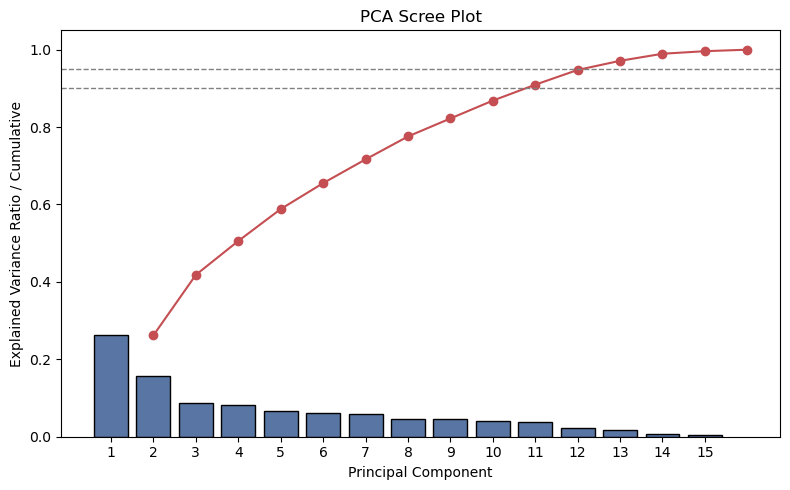

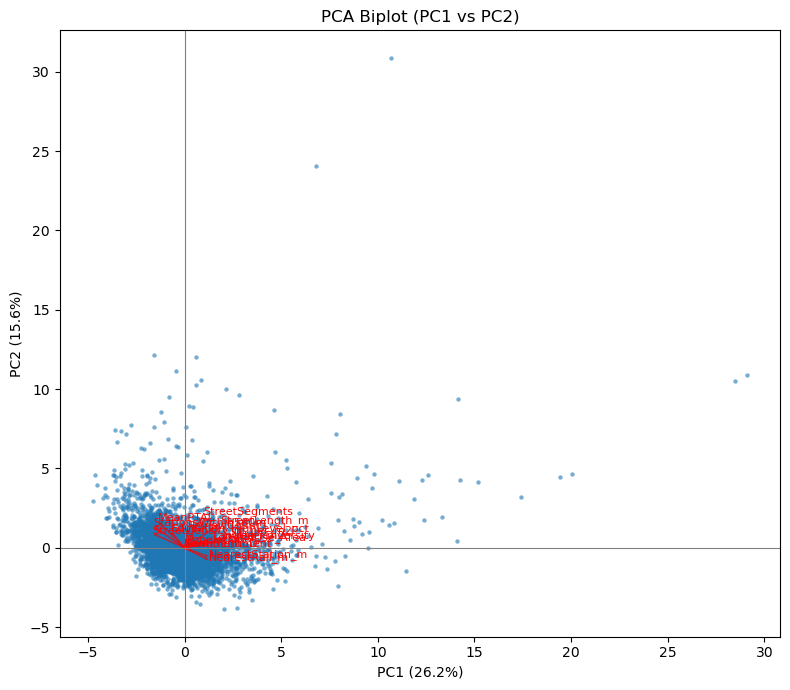

PCA Summary
     PC  ExplainedVarianceRatio  CumulativeExplainedVariance  Eigenvalue
0   PC1                0.262026                     0.262026    3.931230
1   PC2                0.156261                     0.418288    2.344417
2   PC3                0.087433                     0.505721    1.311774
3   PC4                0.082501                     0.588221    1.237771
4   PC5                0.066980                     0.655202    1.004919
5   PC6                0.061342                     0.716544    0.920332
6   PC7                0.059268                     0.775813    0.889215
7   PC8                0.046469                     0.822282    0.697184
8   PC9                0.046141                     0.868423    0.692268
9  PC10                0.041100                     0.909523    0.616626

🔝 Top features by communality (95% PCs):
                         Communality_95pct
Feature                                   
SentimentSD                       1.000178
Population    

In [13]:
from sklearn.decomposition import PCA
import seaborn as sns

# PCA analysis on standardized GCN feature matrix

import matplotlib.pyplot as plt

# 1) Prepare data
X = df_gcn_scaled[feature_cols].to_numpy()
ids = df_gcn_scaled['LSOA_CODE'].values

# 2) Fit PCA (all components)
pca = PCA(n_components=len(feature_cols), svd_solver='full')
scores = pca.fit_transform(X)  # PC scores

explained = pca.explained_variance_ratio_
cum_explained = explained.cumsum()
eigenvalues = pca.explained_variance_

# Determine components for 90% and 95% variance
n90 = int(np.searchsorted(cum_explained, 0.90) + 1)
n95 = int(np.searchsorted(cum_explained, 0.95) + 1)

print(f"PCA fitted on {len(feature_cols)} features")
print(f"  • Variance explained by PC1: {explained[0]*100:.2f}%")
print(f"  • Components for 90%: {n90}, for 95%: {n95}")
print(f"  • Total components: {len(feature_cols)}")

# 3) Build result DataFrames
pc_labels = [f'PC{i+1}' for i in range(len(feature_cols))]

explained_df = pd.DataFrame({
    'PC': pc_labels,
    'ExplainedVarianceRatio': explained,
    'CumulativeExplainedVariance': cum_explained,
    'Eigenvalue': eigenvalues
})

# Loadings (correlation of features with PCs)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)  # shape: (features, pcs)
loadings_df = pd.DataFrame(loadings, index=feature_cols, columns=pc_labels)

# Feature contributions per PC (squared loadings normalized)
contrib = (loadings ** 2)
contrib_df = contrib / contrib.sum(axis=0, keepdims=True)
contrib_df = pd.DataFrame(contrib_df, index=feature_cols, columns=pc_labels)

# Communalities (across retained PCs for 95% variance)
communalities = (loadings[:, :n95] ** 2).sum(axis=1)
communality_df = pd.DataFrame({'Feature': feature_cols, 'Communality_95pct': communalities}).set_index('Feature').sort_values('Communality_95pct', ascending=False)

# Scores with IDs
scores_df = pd.DataFrame(scores, columns=pc_labels)
scores_df.insert(0, 'LSOA_CODE', ids)

# Top features per PC by absolute loading
top_list = []
top_k = min(10, len(feature_cols))
for i, pc in enumerate(pc_labels):
    abs_load = loadings_df[pc].abs().sort_values(ascending=False)
    top_feats = abs_load.head(top_k).index.tolist()
    top_vals = loadings_df.loc[top_feats, pc].values
    for f, v in zip(top_feats, top_vals):
        top_list.append({'PC': pc, 'Feature': f, 'Loading': v, 'AbsLoading': abs(v)})
top_features_df = pd.DataFrame(top_list).sort_values(['PC', 'AbsLoading'], ascending=[True, False])

# 4) Plots
plt.figure(figsize=(8, 5))
sns.barplot(x=np.arange(1, len(feature_cols)+1), y=explained, color='#4C72B0', edgecolor='black')
plt.plot(np.arange(1, len(feature_cols)+1), cum_explained, marker='o', color='#C44E52')
plt.axhline(0.90, color='grey', ls='--', lw=1)
plt.axhline(0.95, color='grey', ls='--', lw=1)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio / Cumulative')
plt.title('PCA Scree Plot')
plt.tight_layout()
plt.show()

# Biplot (PC1 vs PC2)
plt.figure(figsize=(8, 7))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1], s=10, alpha=0.6, linewidth=0)
plt.axhline(0, color='grey', lw=0.8)
plt.axvline(0, color='grey', lw=0.8)
plt.xlabel(f'PC1 ({explained[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}%)')
plt.title('PCA Biplot (PC1 vs PC2)')

# Arrows for features
arrow_scale = 2.5  # visual scaling
for i, feat in enumerate(feature_cols):
    x_arrow = loadings[i, 0] * arrow_scale
    y_arrow = loadings[i, 1] * arrow_scale
    plt.arrow(0, 0, x_arrow, y_arrow, color='red', alpha=0.6, head_width=0.08, length_includes_head=True)
    plt.text(x_arrow*1.07, y_arrow*1.07, feat, fontsize=8, color='red')

plt.tight_layout()
plt.show()

# 5) Save outputs
pca_files = {
    'explained': 'pca_explained_variance.csv',
    'loadings': 'pca_loadings.csv',
    'contrib': 'pca_feature_contributions.csv',
    'scores': 'pca_scores.csv',
    'communality': 'pca_communalities_95pct.csv',
    'top_features': 'pca_top_features_per_pc.csv',
    'scree_plot': 'pca_scree.png',
    'biplot': 'pca_biplot_pc1_pc2.png'
}

explained_df.to_csv(pca_files['explained'], index=False)
loadings_df.to_csv(pca_files['loadings'])
contrib_df.to_csv(pca_files['contrib'])
scores_df.to_csv(pca_files['scores'], index=False)
communality_df.to_csv(pca_files['communality'])
top_features_df.to_csv(pca_files['top_features'], index=False)

# Save figures
plt.figure(figsize=(8, 5))
sns.barplot(x=np.arange(1, len(feature_cols)+1), y=explained, color='#4C72B0', edgecolor='black')
plt.plot(np.arange(1, len(feature_cols)+1), cum_explained, marker='o', color='#C44E52')
plt.axhline(0.90, color='grey', ls='--', lw=1)
plt.axhline(0.95, color='grey', ls='--', lw=1)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio / Cumulative')
plt.title('PCA Scree Plot')
plt.tight_layout()
plt.savefig(pca_files['scree_plot'], dpi=150)
plt.close()

plt.figure(figsize=(8, 7))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1], s=10, alpha=0.6, linewidth=0)
plt.axhline(0, color='grey', lw=0.8)
plt.axvline(0, color='grey', lw=0.8)
plt.xlabel(f'PC1 ({explained[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}%)')
plt.title('PCA Biplot (PC1 vs PC2)')
for i, feat in enumerate(feature_cols):
    x_arrow = loadings[i, 0] * arrow_scale
    y_arrow = loadings[i, 1] * arrow_scale
    plt.arrow(0, 0, x_arrow, y_arrow, color='red', alpha=0.6, head_width=0.08, length_includes_head=True)
    plt.text(x_arrow*1.07, y_arrow*1.07, feat, fontsize=8, color='red')
plt.tight_layout()
plt.savefig(pca_files['biplot'], dpi=150)
plt.close()

# 6) Print concise summary
print("PCA Summary")
print(explained_df.head(10))
print("\n🔝 Top features by communality (95% PCs):")
print(communality_df.head(10))
print("\nPCA outputs saved:")
for k, v in pca_files.items():
    if v.endswith('.png') or v.endswith('.csv'):
        try:
            sz = os.path.getsize(v) / (1024 * 1024)
            print(f"  - {v} ({sz:.2f} MB)")
        except Exception:
            print(f"  - {v}")